# Default settings

In [1]:
# config defaults
default_config = { 
    "SKULLSTRIP" : "1",
    "SLICETIME"  : "1",
    "MOTCOR"     : "1",
    "NORM"       : "1",
    "SMOOTH"     : "6", # gaussian smoothing kernel size in mm
    "MOTREG"     : "1",
    "GSR"        : "1",
    "NUISANCE"   : "3",
    "TEMPLATE"   : "/usr/local/fsl/data/standard/MNI152_T1_2mm_brain.nii.gz",
    "SCRUB"      : "UNION" # union, intersect, dvars, fd, none
}

In [2]:
step_order={
    "BASELINE"  :0,
    "SKULLSTRIP":1,
    "SLICETIME" :2,
    "MOTCOR"    :3,
    "NORM"      :4,
    "GSR"       :5,
    "MOTREG"    :6,
    "NUISANCE"  :7,
    "SCRUB"     :8,
    "SMOOTH"    :9
}

# Support functions

In [3]:
def create_dirstruct(output):
    import pathlib 
    import os

    pathlib.Path(os.path.join(output, "func"           )).mkdir(parents=True, exist_ok=True)
    pathlib.Path(os.path.join(output, "anat", "segment")).mkdir(parents=True, exist_ok=True)
    pathlib.Path(os.path.join(output, "spat_norm"      )).mkdir(parents=True, exist_ok=True)
    pathlib.Path(os.path.join(output, "motion"         )).mkdir(parents=True, exist_ok=True)

    return

In [4]:
def check_exist(filepath, type="any"):
    if type=='f':
        type='file'
    elif type=='d':
        type='dir'

    if type=='file':
        from os.path import isfile as exists
    elif type=="dir":
        from os.path import isdir as exists
    elif type=="any":
        from os.path import exists
    else:
        raise Exception("type '" + type + "' is invalid.")
    
    return(exists(filepath))

In [5]:
def parse_line(text, keywords, split="="):
    key, val = text.split("=")
    if key not in keywords:
        raise Exception("Input doesn't contain any of the specified key words")
    return(key, val)

In [6]:
def strip_chars(text, first, last):
    text = "{}".format(text[1:] if text.startswith(first) else text)
    text = "{}".format(text[:-1] if text.endswith(last) else text)
    return(text)

In [7]:
def parse_input(text, keywords, split="=", first="[", last="]"):
    key, val = parse_line(text, keywords, split)
    val = strip_chars(val, "[", "]")
    return(key, val)

In [8]:
def check_defaults(config_dict, defaults):
    default_keys=[key for key in defaults.keys()]

    restore_defaults=[key not in config_dict.keys() for key in default_keys]
    restore_defaults=list(filter(lambda x: restore_defaults[x], range(len(restore_defaults))))
    restore_defaults=[default_keys[i] for i in restore_defaults]

    for key in restore_defaults:
        config_dict[key] = defaults[key]

    return(config_dict)


In [9]:
def voxel_size(img, excl_time=True):
    import nibabel as nib

    nii = nib.load(img)
    vox_sz = nii.header.get_zooms()

    if excl_time:
        vox_sz=vox_sz[0:3]
    return(vox_sz)

In [10]:
def interpret_input_line(line, keywords):
    input_dict = {}
    items = line.split(",")
    
    for item in items:
        item=item.strip()
        
        try:
            key, val = parse_input(item, keywords) # keywords must be enterest as a list
            input_dict[key] = val
        except:
            print("Error:", item)

    # check if all the files exist 
    if not check_exist(input_dict["FUNC"], "file"):
        raise Exception(input_dict["FUNC"] + " is not a valid filepath.")
    if not check_exist(input_dict["ANAT"], "file"):
        raise Exception(input_dict["ANAT"] + " is not a valid filepath.")
       
    return(input_dict)

In [11]:
# interpret input
def interpret_input(filepath):
    import pandas as pd

    input=open(filepath, "r")
    lines=input.readlines()

    keywords = ["FUNC", "ANAT", "OUTPUT"]
    input_df = pd.DataFrame(index=range(len(lines)), columns=keywords)

    for line, ind in zip(lines, range(len(lines))):
        line=line.strip()
        input_dict=interpret_input_line(line, keywords)

        input_df.loc[ind,"FUNC"  ] = input_dict["FUNC"]
        input_df.loc[ind,"ANAT"  ] = input_dict["ANAT"]
        input_df.loc[ind,"OUTPUT"] = input_dict["OUTPUT"]

    return(input_df)
    

In [12]:
# interpret config
def interpret_config(filepath):
    config=open(filepath, "r")
    lines=config.readlines()

    keywords=["SKULLSTRIP", "SLICETIME", "MOTCOR", "NORM", "SMOOTH", "MOTREG", "GSR", "NUISANCE", "TEMPLATE", "SCRUB"]

    config_dict = {}

    for line in lines:
        line=line.strip()
        try:
            key, val = parse_input(line, keywords) # keywords must be enterest as a list
            config_dict[key] = val
        except:
            print("Error:", line)

    config_dict = check_defaults(config_dict, default_config)
    return(config_dict)

In [13]:
def afni2nifti(filepath, rm_orig=True):
    import os
    
    nii_filepath=os.path.join(os.path.dirname(filepath), rm_ext(filepath))+".nii"
    os.system("3dAFNItoNIFTI -prefix {} {}".format(nii_filepath, filepath+"*.HEAD"))
    if rm_orig:
        os.system("rm {}*.HEAD".format(filepath))
        os.system("rm {}*.BRIK".format(filepath))
    return(nii_filepath)

In [14]:
def getTR(filepath):
    import nibabel as nib
    
    img = nib.load(filepath)
    tr  = img.header.get_zooms()[3]
    return(str(tr)) 

In [15]:
def rm_ext(filename):
    from os.path import splitext
    from os.path import basename

    filename=basename(filename)
    newpath=splitext(filename)[0]
    
    if "." in newpath:
        newpath=rm_ext(newpath)
    return(newpath)  

In [16]:
def get_ext(filename):
    from os.path import splitext
    from os.path import basename

    filename=basename(filename)
    newname, ext=splitext(filename)
    
    if "." in newname:
        ext = get_ext(newname) + ext
    return(ext)

In [17]:
def gauss_mm2sigma(mm):
    sigma=mm/2.35482004503
    return(sigma)


In [18]:
def which(list, x=True):
    coords=[]
    iter=0
    
    for elem in list:
        if elem == x:
            coords.append(iter)
        iter+=1
    return(coords)

In [19]:
def gzip_file(filename, rm_orig=True):
    import gzip
    import shutil
    from os import remove
    
    with open(filename, 'rb') as f_in:
        with gzip.open(filename+'.gz', 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
        if rm_orig:
            remove(filename)
    return(filename+'.gz')

In [20]:
def get_key(val, my_dict):
    for key, value in my_dict.items():
         if val == value:
             return key

In [21]:
def get_step(my_dict, ref_dict, which="prev", ignore=["BASELINE"], give="key"):
    if ignore is None:
        ignore=[]
    if which == "first":
        target=min
    elif which == "prev":
        target=max
    my_keys = list(my_dict.keys())
    for ig in ignore:
        if ig in my_keys:
            pass
        my_keys.remove(ig)
    
    key_val = [ref_dict[key] for key in my_keys]
    if give=="key":
        return get_key(target(key_val), ref_dict)
    elif give=="value":
        return target(key_val)

# Preprocessing Functions

In [22]:
def brainroi(img, out_dir):
    import os

    roi_img = os.path.join(out_dir, "roi_"+os.path.basename(img))
    os.system("robustfov -i {} -r {}".format(img, roi_img))

    return(roi_img)

In [23]:
def skullstrip(img, out_dir):
    import os

    out_dir  = os.path.join(out_dir, "anat")
    out_file = "brain_" + rm_ext(img)
    skullstr = os.path.join(out_dir, out_file)

    print("SKULLSTRIPPING")

    os.system("bet {} {} -R".format(img, skullstr))
    return(skullstr)

In [24]:
def slicetime(img, out_dir):
    import os

    tr=getTR(img)
    tshift_path=os.path.join(out_dir, "func", "t_" + rm_ext(img)+".nii.gz")
    
    print("SLICETIME CORRECTION")
    os.system("3dTshift -TR {}s -prefix {} {}".format(tr, tshift_path, img))

    return(tshift_path)

In [25]:
def motcor(img, out_dir):
    import os

    prefix="m"

    motcor_path=os.path.join(out_dir, "func", "m_"+os.path.basename(img))
    _1dfile_path=os.path.join(out_dir, "motion", "1d_"+rm_ext(os.path.basename(img))+".1D")

    print("MOTION CORRECTION")

    os.system("3dvolreg -base 0 -prefix {} -1Dfile {} {}".format(motcor_path, _1dfile_path, img))
    afni2nifti(motcor_path)

    return(motcor_path, _1dfile_path)

In [26]:
# new spatial normalization
def spatnorm(f_img, a_img, template, out_dir):
    print("SPATIAL NORMALIZATION")
    import os

    # lin warp func to struct
    print("       + Linear-warping functional to structural...")
    l_func_omat=os.path.join(out_dir, "spat_norm", "func2str.mat")
    os.system("flirt -ref {} -in {} -omat {} -dof 6".format(a_img, f_img, l_func_omat))
    
    # lin warp struct to template
    print("       + Linear-warping structural to standard template...")
    l_anat_img =os.path.join(out_dir, "anat", "l_" + os.path.basename(a_img))
    l_anat_omat=os.path.join(out_dir, "spat_norm", "aff_str2std.mat")
    os.system("flirt -ref {} -in {} -omat {} -out {}".format(template, a_img, l_anat_omat, l_anat_img))
    
    # non-lin warp struct to template
    print("       + Non-linear-warping structural to standard template...")
    nl_anat_img  =os.path.join(out_dir, "anat", "n" + os.path.basename(l_anat_img))
    cout_anat_img=os.path.join(out_dir, "anat", "cout_" + os.path.basename(nl_anat_img))
    os.system("fnirt --ref={} --in={} --aff={} --iout={} --cout={} --subsamp=2,2,2,1".format(template, a_img, l_anat_omat, nl_anat_img, cout_anat_img))
    
    # make binary mask from non-lin warped image
    print("       + Creating binary mask from non-linearly warped image...")
    bin_nl_anat_img=os.path.join(out_dir, "anat", "bin_" + os.path.basename(nl_anat_img))
    os.system("fslmaths {} -bin {}".format(nl_anat_img, bin_nl_anat_img))
    
    # apply std warp to func data
    print("       + Applying standardized warp to functional data...")
    nl_func_img=os.path.join(out_dir, "func", "nl_"+os.path.basename(f_img))
    os.system("applywarp --ref={} --in={} --out={} --warp={} --premat={}".format(template, f_img, nl_func_img, cout_anat_img, l_func_omat))

    # create tempalte mask
    print("       + Creating binary template mask...")
    mask_path=os.path.join(out_dir, "anat", "mask_" + os.path.basename(template))
    os.system("fslmaths {} -bin {}".format(template, mask_path))

    return(nl_anat_img, nl_func_img, cout_anat_img, l_anat_omat) # anat, func, warp, premat

In [27]:
def applywarp(in_img, out_img, ref_img, warp_img, premat):
    import os
    os.system("fnirt --ref={} --in={} --aff={} --iout={} --cout={} --subsamp=2,2,2,1".format(ref_img, in_img, premat, out_img, warp_img))
    return(out_img)

In [28]:
def segment(img, out_dir=None):
    import os

    if out_dir is None:
        out_dir = os.path.dirname(img)
    seg_path = os.path.join(out_dir, "seg")
    os.system("fast -n 3 -t 1 -o '{}' '{}'".format(seg_path, img))

    return(seg_path)

In [29]:
def bin_mask(mask, thr=0.5):
    import os

    output = os.path.join(os.path.dirname(mask), "bin_"+os.path.basename(mask))
    os.system("fslmaths {} -thr {} -bin {}".format(mask, thr, output))
    
    return(output)

In [30]:
def roi_tcourse(img, mask, save_path):
    import os

    # compute the mean time course for ROI
    os.system("fslmeants -i '{}' -m '{}' -o '{}'".format(img, mask, save_path))
    
    return(save_path)

In [31]:
def spat_smooth(img, mm, out_dir):
    import os

    print("SMOOTHING FUNCTIONAL DATA")
    
    sigma=gauss_mm2sigma(mm)
    s_img=os.path.join(out_dir, "s_"+os.path.basename(img))
    
    os.system("fslmaths {} -kernel gauss {} -fmean {}".format(img, sigma, s_img))
    
    return(s_img)

In [32]:
def combine_nuis(nuis1, nuis2, output):
    import pandas as pd 

    if nuis1 is None:
        nuis2_pd=pd.read_csv(nuis2, sep="\s+", header=None)
        nuis2_pd.to_csv(output, sep="\t")
        return(output)
    elif nuis2 is None:
        nuis1_pd=pd.read_csv(nuis1, sep="\s+", header=None)
        nuis1_pd.to_csv(output, sep="\t")
        return(output)

    nuis1_pd=pd.read_csv(nuis1, sep="\s+", header=None)
    nuis2_pd=pd.read_csv(nuis2, sep="\s+", header=None)

    nuis_cbind = pd.concat([nuis1_pd, nuis2_pd], axis=1)
    nuis_cbind.to_csv(output, sep="\t", header=False, index=False)

    return(output)

In [33]:
def nuis_reg(img, _1d, out_dir, pref="nuis", poly="1"):
    import os

    clean_img=os.path.join(out_dir, pref + "_" + rm_ext(img) + ".nii.gz")
    command  ="3dDeconvolve -input {} -ortvec  {} {} -polort {} -errts {}".format(img, _1d, pref, poly, clean_img)

    os.system(command)

    return(clean_img)

In [57]:
def meantsBOLD(img, outdir, nomoco):
    import os
    import pandas as pd
    from time import sleep

    print("COMPUTING DVARS")

    dvars_txt = os.path.join(outdir, "dvars.1D")
    dvars_png = os.path.join(outdir, "dvars.png")

    out_compound = os.path.join(outdir, "dvars_outCols.1D")
    out_outliers = os.path.join(outdir, "dvars_outliers.1D")

    command="fsl_motion_outliers -i {} -o {} -s {} -p {} --dvars".format(img, out_compound, dvars_txt, dvars_png)
    if nomoco:
        command+=" --nomoco"

    os.system(command)

    sleep(10)
    dvars_out=pd.read_csv(out_compound, delim_whitespace=True, header=False)
    dvars_out=dvars_out.sum(axis=1)
    dvars_out=dvars_out.astype("int")

    dvars_out.to_csv(out_outliers, sep="\t", index=False)

    return(out_outliers)

In [66]:
def fd_out(img, voxel_size, outdir):
    import os
    import pandas as pd
    from time import sleep

    print("COMPUTING FD")

    thresh = voxel_size/2
    fd_txt = os.path.join(outdir, "fd.1D")
    fd_png = os.path.join(outdir, "fd.png")

    out_compound = os.path.join(outdir, "fd_outCols.1D")
    out_outliers = os.path.join(outdir, "fd_outliers.1D")

    os.system("fsl_motion_outliers -i {} -o {} -s {} -p {} --fd --thresh={}".format(img, out_compound, fd_txt, fd_png, thresh))

    sleep(10)
    fd_out=pd.read_csv(out_compound, delim_whitespace=True, header=False)
    fd_out=fd_out.sum(axis=1)
    fd_out=fd_out.astype("int")

    fd_out.to_csv(out_outliers, sep="\t", index=False)

    return(out_outliers)


In [69]:
def mk_outliers(dvars, fd, out_dir, method="UNION"):
    import os
    import pandas as pd

    print("FLAGGING OUTLIERS")

    fd_mat    = pd.read_csv(fd   , delimiter="\t", header=None)
    dvars_mat = pd.read_csv(dvars, delimiter="\t", header=None)
    
    if method=="UNION":
        outliers_mat = (fd_mat + dvars_mat).astype("bool")
        outliers_mat = outliers_mat.astype("int")
    elif method=="INTERSECT":
        outliers_mat = dvars_mat[0]*fd_mat[0]
        outliers_mat = outliers_mat.dropna()
    elif method=="FD":
        outliers_mat = fd_mat
    elif method=="DVARS":
        outliers_mat = dvars_mat
    
    outlier_path = os.path.join(out_dir, "scrub_outliers.txt")
    
    outliers_mat.to_csv(outlier_path, sep="\t", index=False, header=False)

    return(outlier_path)


In [37]:
def interp_time(img, out, int_ind, return_full=False):
    import numpy as np

    if len(img.shape)!=4:
        raise Exception("Nifti image must have 4 dimensions.")
    
    # make blank image
    int_dim = list(img.shape[0:3])
    int_dim.append(int_ind[1]-int_ind[0]-1)
    int_img = np.empty(int_dim)

    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            for slice in range(img.shape[2]):
                int_val = interp_pts(img[row, col, slice, int_ind[0]], img[row, col, slice, int_ind[1]], int_ind[1]-int_ind[0]-1)
                int_img[row, col, slice, :] = int_val

    if return_full:
        img[:,:,:,out] = int_img
        return(img)
    else:
        return(int_img)


In [38]:
def interp_pts(start, end, nvals, round=True):
    
    step_len=(end-start)/(nvals+1)
    
    interp_set=[start+(step_len*i) for i in range(1,nvals+1)]
    if round:
        interp_set=round_dec(interp_set, [start, end])

    return(interp_set)

In [39]:
def round_dec(vals, ref):
    import decimal

    n_places=max([n_dec(i) for i in ref])
    rnd_vals=[round(i, n_places) for i in vals]

    return(rnd_vals)

In [40]:
def n_dec(val):
    import decimal

    n_places=abs(decimal.Decimal(str(val)).as_tuple().exponent)
    return(n_places)

In [41]:
def surrounding_timepoints(t_range, ind):

    import numpy as np
    
    sub_ind = np.empty((0,2), dtype=int, order='C')
    
    for ii in ind:
        t_start = ii-1
        t_end   = ii+1
        
        while t_start in ind:
            t_start -= 1
        while t_end in ind:
            t_end += 1
        
        if t_start < min(t_range):
            t_start = "NaN"
        if t_end < min(t_range):
            t_end = "NaN"
        
        sub_ind = np.vstack([sub_ind, (t_start, t_end)])
        sub_ind = np.unique(sub_ind, axis=0)
    return(sub_ind)

In [42]:
def scrubbing(nifti, outliers, out_dir, interpolate=False):
    import os
    import nibabel as nib
    import numpy as np
    from pandas import read_csv
    from nibabel.testing import data_path
    from scipy.interpolate import RegularGridInterpolator

    print("SCRUBBING fMRI TIME SERIES")

    img = nib.load(nifti)
    mat = img.get_fdata()

    outliers=read_csv(outliers, delimiter="\t", header=None)
    outliers=outliers.values.tolist()
    outliers=which([o[0] for o in outliers], 1)

    print("       + Removing outlier timepoints...")
    mat[:,:,:,outliers]=float("NaN")

    if interpolate:
        print("       + Linearly-interpolating outliers...")
        sub_ind = surrounding_timepoints(range(mat.shape[3]), outliers)

        for oo in range(len(sub_ind)):
            tmp = interp_time(mat, outliers[oo], sub_ind[oo,:], return_full=False)
            mat[:,:,:,(sub_ind[oo,0]+1):sub_ind[oo,1]] = tmp

    new_img = nib.Nifti1Image(mat, img.affine, header=img.header)
    print("       + Saving scrubbed timeseries...")
    scrub_path=os.path.join(out_dir, "scrub_"+rm_ext(os.path.basename(nifti))+".nii")
    nib.save(new_img, scrub_path)
    
    scrub_path=gzip_file(scrub_path)

    return(scrub_path)


# Quality Control

In [42]:
def ica(img, mask, out):
    from nilearn.decomposition import CanICA

    canica=CanICA(n_components=20, memory_level=1, mask=mask, random_state=0, n_jobs=-2, n_init=20)
    canica.fit(img)

    canica.components_img_
    canica.components_img_.to_filename(out)



# Wrappers

In [43]:
def wrapper_lvl2(input_file, config_file):
    config=interpret_config(config_file)
    input =interpret_input(input_file)

    nrow = len(input.index)
    
    for row in range(nrow):
        wrapper_lvl1(input.loc[row,:], config)
        print("")
    return(input, config)

In [44]:
def wrapper_lvl1(input, config):
    import os
    import subprocess

    create_dirstruct(input["OUTPUT"])

    cur_func=os.path.join(input["OUTPUT"], "func", "func" + get_ext(input["FUNC"]))
    cur_anat=os.path.join(input["OUTPUT"], "anat", "MPRage" + get_ext(input["ANAT"]))

    os.system("cp {} {}".format(input["FUNC"], cur_func))
    os.system("cp {} {}".format(input["ANAT"], cur_anat))

    # create empty dictionary
    pipe_steps={}

    # add voxel size
    voxel_sz=voxel_size(cur_func, incl_time=False)

    # add baseline
    pipe_steps={"BASELINE":{"func":cur_func, "anat":cur_anat, "voxel_size":voxel_sz}}
    
    if config["SKULLSTRIP"]=="1": # will always run on the baseline
        step = get_step(pipe_steps, step_order, which="prev", ignore=None)
        
        cur_anat      = skullstrip(pipe_steps["BASELINE"]["anat"], input["OUTPUT"])
        pipe_steps["SKULLSTRIP"] = {"anat":cur_anat, "func":pipe_steps["BASELINE"]["anat"]}
    
    if config["SLICETIME"]=="1":
        step = get_step(pipe_steps, step_order, which="prev", ignore=None)

        cur_func      = slicetime(cur_func, input["OUTPUT"])
        pipe_steps["SLICETIME"] = {"anat":pipe_steps[step]["anat"], "func":cur_func}
    
    if config["MOTCOR"]=="1":
        step = get_step(pipe_steps, step_order, which="prev", ignore=None)

        cur_func, _1dfile_path=motcor(pipe_steps[step]["func"], input["OUTPUT"])
        pipe_steps["MOTCOR"] = {"anat":pipe_steps[step]["anat"], "func":cur_func, "mot_estim":_1dfile_path}
    
    if config["NORM"]=="1":
        step = get_step(pipe_steps, step_order, which="prev", ignore=None)

        cur_anat, cur_func, nl_warp, nl_premat=spatnorm(pipe_steps[step]["func"], pipe_steps[step]["anat"], config["TEMPLATE"], input["OUTPUT"])        
        pipe_steps["NORM"]={"anat":cur_anat, "func":cur_func, "nl_warp":nl_warp, "nl_premat":nl_premat}
    if config["NUISANCE"]!="0":
        step = get_step(pipe_steps, step_order, which="prev", ignore=None)

        nuis_path=os.path.join(input["OUTPUT"], "motion", "nuisance_regressors.1D")

        if config["GSR"]=="1":
            step = get_step(pipe_steps, step_order, which="prev", ignore=None)

            print("GLOBAL SIGNAL REGRESSION")
            print("       + Segmenting anatomical image...")
            csf_mask=segment(pipe_steps[step]["anat"], os.path.join(input["OUTPUT"], "anat", "segment")) + "_pve_0.nii.gz"
            
            print("       + Binarizing CSF Mask...")
            bin_csf_mask=bin_mask(csf_mask, 0.75)
            
            gs_tcourse_path=os.path.join(input["OUTPUT"], "motion", "global_signal.1D")
            gs_tcourse=roi_tcourse(pipe_steps[step]["func"], bin_csf_mask, gs_tcourse_path)
        else:
            gs_tcourse=None

        if config["MOTREG"]=="1":
            mot_tcourse=pipe_steps["MOTCOR"]["mot_estim"]
        else:
            mot_tcourse=None

        # I see a little sihlouette of a man
        if mot_tcourse is None and gs_tcourse is None:
            raise ValueError("Must enable at least one of the following to perform nuisance regression: MOTCOR, GSR")
        
        nuis_tab=combine_nuis(mot_tcourse, gs_tcourse, nuis_path)

        cur_func = nuis_reg(pipe_steps[step]["func"], nuis_tab, os.path.join(input["OUTPUT"],"func"), pref="nuis",poly=config["NUISANCE"])

        pipe_steps["NUISANCE"]={"anat":pipe_steps[step]["anat"], "func":cur_func, "csf_mask":bin_csf_mask, "gsr":gs_tcourse, "mot_reg":mot_tcourse, "nuis_reg":nuis_tab}    

    if float(config["SMOOTH"]) > 0:
        step = get_step(pipe_steps, step_order, which="prev", ignore=None)

        cur_func=spat_smooth(pipe_steps[step]["func"], float(config["SMOOTH"]), os.path.join(input["OUTPUT"], "func"))

        pipe_steps["SMOOTH"] = {"anat":pipe_steps[step]["anat"], "func":cur_func}
    
    if config["SCRUB"]!="NONE":
        step = get_step(pipe_steps, step_order, which="prev", ignore=None)

        if config["SCRUB"] in ["UNION", "INTERSECT", "FD"]:
            fd_outliers = fd_out(img=pipe_steps["BASELINE"]["func"], voxel_size=sum(voxel_sz)/len(voxel_sz), outdir=os.path.join(input["OUTPUT"], "motion"))
        else:
            fd_outliers = None

        if config["SCRUB"] in ["UNION", "INTERSECT", "DVARS"]:
            nomoco = config["MOTCOR"]=="1"
            if nomoco:
                cur_func=pipe_steps["MOTCOR"]["func"]
            else:
                cur_func=pipe_steps["BASELINE"]["func"]
            dvar_outliers = meantsBOLD(cur_func, os.path.join(input["OUTPUT"], "motion"), nomoco)
        else:
            dvars_outliers = None

        scrub_outliers = mk_outliers(dvar_outliers, fd_outliers, os.path.join(input["OUTPUT"], "motion"), method=config["SCRUB"])
        scrubbed_nifti = scrubbing(pipe_steps[step]["func"], scrub_outliers, os.path.join(input["OUTPUT"], "func"), interpolate=True)

        pipe_steps["SCRUB"] = {"anat":pipe_steps[step]["anat"], "func":scrubbed_nifti, "scrub_outliers":scrub_outliers, "fd":fd_outliers, "dvars":dvar_outliers, "method":config["SCRUB"]}


In [ ]:
# implementing cases

def wrapper_lvl1(input, config):
    import os
    import subprocess

    create_dirstruct(input["OUTPUT"])

    cur_func=os.path.join(input["OUTPUT"], "func", "func" + get_ext(input["FUNC"]))
    cur_anat=os.path.join(input["OUTPUT"], "anat", "MPRage" + get_ext(input["ANAT"]))

    os.system("cp {} {}".format(input["FUNC"], cur_func))
    os.system("cp {} {}".format(input["ANAT"], cur_anat))

    # create empty dictionary
    pipe_steps={}

    # add voxel size
    voxel_sz=voxel_size(cur_func, incl_time=False)

    # add baseline
    pipe_steps={"BASELINE":{"func":cur_func, "anat":cur_anat, "voxel_size":voxel_sz}}
    
    if config["SKULLSTRIP"]=="1": # will always run on the baseline
        step = get_step(pipe_steps, step_order, which="prev", ignore=None)
        
        cur_anat      = skullstrip(pipe_steps["BASELINE"]["anat"], input["OUTPUT"])
        pipe_steps["SKULLSTRIP"] = {"anat":cur_anat, "func":pipe_steps["BASELINE"]["anat"]}
    
    if config["SLICETIME"]=="1":
        step = get_step(pipe_steps, step_order, which="prev", ignore=None)

        cur_func      = slicetime(cur_func, input["OUTPUT"])
        pipe_steps["SLICETIME"] = {"anat":pipe_steps[step]["anat"], "func":cur_func}
    
    if config["MOTCOR"]=="1":
        step = get_step(pipe_steps, step_order, which="prev", ignore=None)

        cur_func, _1dfile_path=motcor(pipe_steps[step]["func"], input["OUTPUT"])
        pipe_steps["MOTCOR"] = {"anat":pipe_steps[step]["anat"], "func":cur_func, "mot_estim":_1dfile_path}
    
    if config["NORM"]=="1":
        step = get_step(pipe_steps, step_order, which="prev", ignore=None)

        cur_anat, cur_func, nl_warp, nl_premat=spatnorm(pipe_steps[step]["func"], pipe_steps[step]["anat"], config["TEMPLATE"], input["OUTPUT"])        
        pipe_steps["NORM"]={"anat":cur_anat, "func":cur_func, "nl_warp":nl_warp, "nl_premat":nl_premat}
    if config["NUISANCE"]!="0":
        step = get_step(pipe_steps, step_order, which="prev", ignore=None)

        nuis_path=os.path.join(input["OUTPUT"], "motion", "nuisance_regressors.1D")

        if config["GSR"]=="1":
            step = get_step(pipe_steps, step_order, which="prev", ignore=None)

            print("GLOBAL SIGNAL REGRESSION")
            print("       + Segmenting anatomical image...")
            csf_mask=segment(pipe_steps[step]["anat"], os.path.join(input["OUTPUT"], "anat", "segment")) + "_pve_0.nii.gz"
            
            print("       + Binarizing CSF Mask...")
            bin_csf_mask=bin_mask(csf_mask, 0.75)
            
            gs_tcourse_path=os.path.join(input["OUTPUT"], "motion", "global_signal.1D")
            gs_tcourse=roi_tcourse(pipe_steps[step]["func"], bin_csf_mask, gs_tcourse_path)
        else:
            gs_tcourse=None

        if config["MOTREG"]=="1":
            mot_tcourse=pipe_steps["MOTCOR"]["mot_estim"]
        else:
            mot_tcourse=None

        # I see a little sihlouette of a man
        if mot_tcourse is None and gs_tcourse is None:
            raise ValueError("Must enable at least one of the following to perform nuisance regression: MOTCOR, GSR")
        
        nuis_tab=combine_nuis(mot_tcourse, gs_tcourse, nuis_path)

        cur_func = nuis_reg(pipe_steps[step]["func"], nuis_tab, os.path.join(input["OUTPUT"],"func"), pref="nuis",poly=config["NUISANCE"])

        pipe_steps["NUISANCE"]={"anat":pipe_steps[step]["anat"], "func":cur_func, "csf_mask":bin_csf_mask, "gsr":gs_tcourse, "mot_reg":mot_tcourse, "nuis_reg":nuis_tab}    

    if float(config["SMOOTH"]) > 0:
        step = get_step(pipe_steps, step_order, which="prev", ignore=None)

        cur_func=spat_smooth(pipe_steps[step]["func"], float(config["SMOOTH"]), os.path.join(input["OUTPUT"], "func"))

        pipe_steps["SMOOTH"] = {"anat":pipe_steps[step]["anat"], "func":cur_func}
    
    if config["SCRUB"]!="NONE":
        step = get_step(pipe_steps, step_order, which="prev", ignore=None)

        if config["SCRUB"] in ["UNION", "INTERSECT", "FD"]:
            fd_outliers = fd_out(img=pipe_steps["BASELINE"]["func"], voxel_size=sum(voxel_sz)/len(voxel_sz), outdir=os.path.join(input["OUTPUT"], "motion"))
        else:
            fd_outliers = None

        if config["SCRUB"] in ["UNION", "INTERSECT", "DVARS"]:
            nomoco = config["MOTCOR"]=="1"
            if nomoco:
                cur_func=pipe_steps["MOTCOR"]["func"]
            else:
                cur_func=pipe_steps["BASELINE"]["func"]
            dvar_outliers = meantsBOLD(cur_func, os.path.join(input["OUTPUT"], "motion"), nomoco)
        else:
            dvars_outliers = None

        scrub_outliers = mk_outliers(dvar_outliers, fd_outliers, os.path.join(input["OUTPUT"], "motion"), method=config["SCRUB"])
        scrubbed_nifti = scrubbing(pipe_steps[step]["func"], scrub_outliers, os.path.join(input["OUTPUT"], "func"), interpolate=True)

        pipe_steps["SCRUB"] = {"anat":pipe_steps[step]["anat"], "func":scrubbed_nifti, "scrub_outliers":scrub_outliers, "fd":fd_outliers, "dvars":dvar_outliers, "method":config["SCRUB"]}

In [ ]:
def qc_wrapper():
    return

# TESTING AREA

In [93]:
input_filepath  = "/mnt/d/Downloads/ds000031-download/input.txt"
config_filepath = "/mnt/d/Downloads/ds000031-download/config.txt"

input, config=wrapper_lvl2(input_filepath, config_filepath)

SKULLSTRIPPING
SLICETIME CORRECTION
MOTION CORRECTION
COMPUTING FD
COMPUTING DVARS
       + Segmenting anatomical image...
cur_func = /mnt/d/Downloads/ds000031-download/sub-01/ses-003/out/func/m_t_func.nii.gz
csf_mask = /mnt/d/Downloads/ds000031-download/sub-01/ses-003/out/anat/segment/seg_pve_0.nii.gz
SPATIAL NORMALIZATION
       + Linear-warping functional to structural...
       + Linear-warping structural to standard template...
       + Non-linear-warping structural to standard template...
       + Creating binary mask from non-linearly warped image...
       + Applying standardized warp to functional data...
       + Creating binary template mask...
       + Warping CSF mask to standardized space...
       + Binarizing CSF Mask...
GLOBAL SIGNAL REGRESSION
       + Getting CSF timecourse...
       + Regressing out CSF timecourse from functional data...
MOTION REGRESSION
SMOOTHING FUNCTIONAL DATA
FLAGGING OUTLIERS
SCRUBBING fMRI TIME SERIES


FileNotFoundError: No such file or no access: '/mnt/d/Downloads/ds000031-download/sub-01/ses-003/out/func/s_motreg_gsr_nl_m_t_func.nii.gz'

# ICA

In [16]:
# import nilearn as nil
from nilearn.decomposition import CanICA

nii="/mnt/d/Downloads/ds000031-download/sub-01/ses-003/out/func/errts.nii.gz"
mask="/mnt/d/Downloads/ds000031-download/sub-01/ses-003/out/mask_MNI152_T1_2mm_brain.nii.gz"

canica=CanICA(n_components=20, memory_level=1, mask=mask, random_state=0, n_jobs=-2, n_init=20)

In [17]:
canica.fit(nii)

CanICA(mask='/mnt/d/Downloads/ds000031-download/sub-01/ses-003/out/mask_MNI152_T1_2mm_brain.nii.gz',
       memory_level=1, n_init=20, n_jobs=-2, random_state=0)

In [68]:
canica.components_img_
canica.components_img_.to_filename("/mnt/d/Downloads/ds000031-download/sub-01/ses-003/out/func/errts_components.nii.gz")

/home/john/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/home/john/.local/lib/python3.8/site-packages/nilearn/plotting/displays.py:101: UserWarning: linewidths is ignored by contourf
  im = getattr(ax, type)(data_2d.copy(),
/home/john/.local/lib/python3.8/site-packages/nilearn/plotting/displays.py:101: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


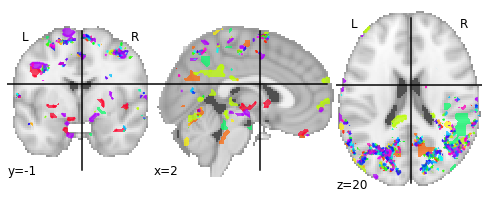

In [10]:
from nilearn import plotting

plotting.plot_prob_atlas(canica.components_img_)

# Run ICA

In [75]:
from nilearn.decomposition import CanICA
from os import listdir
import glob

top_dir="/mnt/d/Downloads/ds000031-download/sub-01/ses-003/out/func"
mask="/mnt/d/Downloads/ds000031-download/sub-01/ses-003/out/anat/mask_MNI152_T1_2mm_brain.nii.gz"

import glob
file_ls=glob.glob(os.path.join(top_dir, "*nl_m_t_func.nii.gz"))

for nii in file_ls:
    ica_path=os.path.join(os.path.dirname(nii), "ica_"+os.path.basename(nii))

    canica=CanICA(n_components=20, memory_level=1, mask=mask, random_state=0, n_jobs=-2, n_init=20)
    canica.fit(nii)
    canica.components_img_
    canica.components_img_.to_filename(ica_path)

['/mnt/d/Downloads/ds000031-download/sub-01/ses-003/out/func/nl_m_t_func.nii.gz',
 '/mnt/d/Downloads/ds000031-download/sub-01/ses-003/out/func/nuis_nl_m_t_func.nii.gz',
 '/mnt/d/Downloads/ds000031-download/sub-01/ses-003/out/func/s_nuis_nl_m_t_func.nii.gz',
 '/mnt/d/Downloads/ds000031-download/sub-01/ses-003/out/func/scrub_s_nuis_nl_m_t_func.nii.gz']